# Gradient descent
Created 06/05/2024

Objectives:
* Apply ADAM gradient descent algorithm to an MPO and extract cohomology.
* Largely a copy and paste of [this](../optimisation/unitary_cost_function/hyperbolic_unitary_overlap_cost_function_adam_gradient_descent_on_two_sided_mpo_spt_extraction_sweep.ipynb).

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../")

In [3]:
from functools import reduce
from operator import mul

import time
import pickle

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np
import pandas as pd

rng = np.random.default_rng()
import matplotlib.pyplot as plt

In [6]:
import re

In [7]:
from SPTOptimization.utils import (
    get_right_identity_environment_from_tp_tensor,
    get_left_identity_environment_from_tp_tensor,
    to_npc_array,
    get_physical_dim
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

# Load data

In [56]:
DATA_DIR_1 = r"../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [57]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [58]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [59]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [60]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [61]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [62]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [63]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [64]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [65]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [66]:
fermionic_np_symmetries = [np_I, np_JW]

In [67]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [68]:
npc_JW = fermionic_npc_symmetries[1]

In [69]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [70]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [71]:
cases_triv_proj_rep = dict()

for k, psi in loaded_data_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_triv_proj_rep[(k, i, j)] = case

In [72]:
for c in cases_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [73]:
cases_non_triv_proj_rep = dict()

for k, psi in loaded_data_non_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_non_triv_proj_rep[(k, i, j)] = case

In [74]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [75]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [76]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## Functions

In [84]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [85]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t

In [86]:
def unitary_order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [87]:
def unitary_order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [88]:
def overlap_right_tensors(w_tensors, b_tensors):
    out = list()

    t = get_right_identity_environment_from_tp_tensor(b_tensors[-1])

    out.append(t)

    # First site
    b = b_tensors[-1]
    w = w_tensors[-1]
    
    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w.replace_label('vL', 'vLm'),
        [['p',], ['p*',]]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    # Inner sites
    for w, b in zip(w_tensors[-2:0:-1], b_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR',]])
        t = npc.tensordot(
            t,
            w.replace_label('vL', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])
    
        out.append(t)

    # Last site
    b = b_tensors[0]
    w = w_tensors[0]

    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w,
        [['p', 'vLm'], ['p*', 'vR']]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    return out[::-1]

### Initialize tensors

In [89]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [90]:
def generate_random_w_tensor(physical_dim, left_virtual_dim=None,
                             right_virtual_dim=None):

    if (left_virtual_dim is None) and (right_virtual_dim is None):
        dims = (physical_dim, physical_dim)
    elif (left_virtual_dim is None):
        dims = (physical_dim, physical_dim, right_virtual_dim)
    elif (right_virtual_dim is None):
        dims = (physical_dim, physical_dim, left_virtual_dim)
    else: 
        dims = (
            physical_dim,
            physical_dim,
            left_virtual_dim,
            right_virtual_dim
        )
    
    X1 = rng.normal(size=dims)
    X2 = 1j*rng.normal(size=dims)
    X = X1 + X2

        
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*'])
    elif right_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vL'])
    elif left_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vR'])
    else:
        out = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return out

In [91]:
def get_random_mpo_tensors(num_sites, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

In [92]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [93]:
def get_random_mpo_tensors(physical_dims, virtual_dims):
    """
    Could fold in with get_identity_mpo_tensors
    """

    w_tensors = [
        generate_random_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

In [94]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

### ADAM functions

In [95]:
def squared_components(X):
    r, i = (X.real, X.imag)
    return r**2 + 1j*(i**2)

In [96]:
def square_root_components(X):
    r, i = (X.real, X.imag)
    return np.sqrt(r) + 1j*np.sqrt(i)

In [97]:
class AdamTenpy:
    def __init__(self, alpha=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

        self.moment_1 = None
        self.moment_2 = None

    def update(self, grad):
        if self.moment_1 is None:
            self.moment_1 = (1-self.beta_1)*grad
        else:
            self.moment_1 = self.beta_1*self.moment_1 + (1-self.beta_1)*grad

        grad_squared = grad.unary_blockwise(squared_components)
        if self.moment_2 is None:
            self.moment_2 = (1-self.beta_2)*grad_squared
        else:
            self.moment_2 = self.beta_2*self.moment_2 + (1-self.beta_2)*grad_squared

        self.moment_1 /= (1-self.beta_1)
        self.moment_2 /= (1-self.beta_2)

        out_grad_denom = (
            self.moment_2
            .unary_blockwise(square_root_components)
            .unary_blockwise(lambda x: x + (1+1j)*self.epsilon)
        )

        out_grad = (
            self.moment_1
            .binary_blockwise(np.divide, out_grad_denom)
        )

        return self.alpha*out_grad

### Sweep function

In [98]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    """
    Update raw_mpo_tensor calculated to be the gradient by changing leg names
    as neeeded so can be easily and consistently added to
    gradient_target_tensor.
    """
    leg_labels = raw_mpo_tensor.get_leg_labels()

    # First update the virtual legs
    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
        ('vLm', 'vR'),
        ('vRm', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    # Then create new array to get the physical legs correct.
    # Is this consistent? Should set order of leg labels on raw_mpo_tensor
    # before casting to array?
    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [99]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]],
                     take_abs=False
                    ):
    # Calculate "score" (just the contraction of the two relevant tensors)
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    if take_abs:
        real_score = np.abs(score)
    else:
        real_score = score.real

    return score

In [100]:
def mpo_gradient_descent_sweep(mpo_tensors, b_tensors, total_dimension,
    right_overlap_tensors, unitarity_learning_rate, overlap_learning_rate,
    overlap_target, left_environment, adam_optimizers):
    """
    Really need to tidy this function up...

    Also get matrix_dim directly from tensors.
    """
    # Initialise list of gradients to be filled
    grads = list()

    # Initialise variables
    right_unitary_two_tensors = unitary_order_two_right_tensors(mpo_tensors)
    right_unitary_four_tensors = unitary_order_four_right_tensors(mpo_tensors)
    
    left_unitary_two_tensors = list()
    left_unitary_four_tensors = list()
    left_overlap_tensors = list()

    num_sites = len(mpo_tensors)
    assert len(mpo_tensors) == len(b_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    b = b_tensors[0]

    t = right_unitary_two_tensors[0]

    # Second order terms
    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    order_2_score = update_mpo_score(
        grad_2,
        w,
        [['vL*',], ['vR*',]]
    )

    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    # Fourth order terms
    t = right_unitary_four_tensors[0]

    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    order_4_score = update_mpo_score(
        grad_4,
        w,
        [['vL1*',], ['vR*',]]
    )

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    unitary_score = order_4_score - 2*order_2_score + total_dimension
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
    # Overlap terms
    t = right_overlap_tensors[0].conj().replace_label('vLm*', 'vLm')

    grad_o = npc.tensordot(t, b, [['vL'], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(grad_o, left_environment, [['vL', 'vL*'], ['vR', 'vR*']])

    c_conj = update_mpo_score(
        grad_o,
        w,
        [['vLm',], ['vR*',]],
        take_abs=True
    )
    c = c_conj.conjugate()
    c_abs = np.abs(c)
    
    grad_o_scale = c*(1 - overlap_target/c_abs)
    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[0].update(grad)
    grads.append(adam_grad)

    # Create and save left tensors
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_unitary_two_tensors.append(t)
    
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    left_unitary_four_tensors.append(t)

    t = npc.tensordot(b, w.conj(), [['p',], ['p*',]])
    #print(t)
    t.ireplace_label('vR*', 'vRm')
    #print(t)
    t = npc.tensordot(t, left_environment, [['vL',], ['vR',]])
    #print(t)
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    #print(t)

    left_overlap_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w = mpo_tensors[i]
        b = b_tensors[i]
    
        right_two_tensor = right_unitary_two_tensors[i]
        right_four_tensor = right_unitary_four_tensors[i]
        right_overlap_tensor = right_overlap_tensors[i].conj().replace_label('vLm*', 'vLm')

        # Order two terms
        left_two_tensor = left_unitary_two_tensors[-1]

        grad_2 = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_2 = npc.tensordot(grad_2, left_two_tensor, [['vL'], ['vR',]])

        grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

        # Order four terms
        left_four_tensor = left_unitary_four_tensors[-1]

        grad_4 = npc.tensordot(right_four_tensor, w, [['vL'], ['vR',]])
        grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        grad_4 = npc.tensordot(
            grad_4,
            w.replace_label('vL', 'vL1'),
            [['vL1', 'p'], ['vR', 'p*']]
        )

        grad_4 = npc.tensordot(
            grad_4,
            left_four_tensor,
            [['vL', 'vL*', 'vL1'], ['vR', 'vR*', 'vR1']]
        )

        grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

        unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
        # Overlap terms
        left_overlap_tensor = left_overlap_tensors[-1]

        grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
        grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
        grad_o = npc.tensordot(
            grad_o,
            left_overlap_tensor,
            [['vL*', 'vL'], ['vR', 'vR*',]]
        )

        grad_o = grad_o_scale*grad_o
        grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

        grad = (
            unitarity_learning_rate*unitary_grad +
            overlap_learning_rate*grad_o
        )
        adam_grad = adam_optimizers[i].update(grad)
        grads.append(adam_grad)

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_unitary_two_tensors.append(t)
        
        t = npc.tensordot(left_four_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(t, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vR1'),
            [['p', 'vR1'], ['p*', 'vL']]
        )
        t = npc.tensordot(
            t,
            w.conj().replace_label('vR*', 'vR1*'),
            [['p', 'p*', 'vR1*'], ['p*', 'p', 'vL*']]
        )
        
        left_unitary_four_tensors.append(t)

        t = left_overlap_tensor.ireplace_label('vR*', 'vR1*')
        t = npc.tensordot(
            left_overlap_tensor,
            w.conj(),
            [['vRm',], ['vL*']]
        )
        t.ireplace_label('vR*', 'vRm')
        t = npc.tensordot(t, b, [['vR', 'p*'], ['vL', 'p']])
        t = npc.tensordot(t, b.conj(), [['vR1*', 'p'], ['vL*', 'p*']])

        left_overlap_tensors.append(t)

    # Last site
    left_two_tensor = left_unitary_two_tensors[-1]
    w = mpo_tensors[-1]
    b = b_tensors[-1]
    
    grad_2 = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    left_four_tensor = left_unitary_four_tensors[-1]
    
    grad_4 = npc.tensordot(left_four_tensor, w, [['vR'], ['vL',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vR1', 'p'], ['vL', 'p*']])

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)
    
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)

    left_overlap_tensor = left_overlap_tensors[-1]
    right_overlap_tensor = right_overlap_tensors[-1].conj()

    grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(
        grad_o,
        left_overlap_tensor,
        [['vL*', 'vL'], ['vR', 'vR*',]]
    )

    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)


    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[-1].update(grad)
    grads.append(adam_grad)

    """
    for i, g in enumerate(grads):
        mpo_tensors[i] = mpo_tensors[i] - g
    """
    
    return (grads, unitary_score, c_abs)

In [101]:
def swap_left_right_indices(npc_array):
    left_right_pairs = {
        'vL': 'vR',
        'vR': 'vL',
        'vL*': 'vR*',
        'vR*': 'vL*'
    }

    leg_labels = npc_array.get_leg_labels()

    old_labels = [l for l in leg_labels if l in left_right_pairs]
    new_labels = [left_right_pairs[l] for l in old_labels]

    out = npc_array.replace_labels(old_labels, new_labels)

    return out

In [102]:
def two_sided_mpo_gradient_descent_sweep(left_mpo_tensors, right_mpo_tensors,
    left_b_tensors, right_b_tensors, left_total_dimension,
    right_total_dimension, unitarity_learning_rate, overlap_learning_rate,
    symmetry_transfer_matrix, left_adam_optimizers, right_adam_optimizers):

    # Compute left and right symmetry environments
    # Right symmetry environment for left side first
    right_overlap_tensors = overlap_right_tensors(
        right_mpo_tensors,
        right_b_tensors
    )
    right_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        right_overlap_tensors[0],
        [['vR', 'vR*'], ['vL', 'vL*']]
    )
    right_symmetry_environment = swap_left_right_indices(right_symmetry_environment)

    # Left symmetry environment for right side
    left_overlap_tensors = overlap_right_tensors(
        left_mpo_tensors,
        left_b_tensors
    )
    left_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        swap_left_right_indices(left_overlap_tensors[0]),
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    # Get right gradients
    right_grads, unitary_score, c_abs = mpo_gradient_descent_sweep(
        right_mpo_tensors,
        right_b_tensors,
        right_total_dimension,
        right_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        left_symmetry_environment,
        right_adam_optimizers
    )
    
    for i, g in enumerate(right_grads):
        right_mpo_tensors[i] = right_mpo_tensors[i] - g

    # Get left gradients
    left_grads, *_ = mpo_gradient_descent_sweep(
        left_mpo_tensors,
        left_b_tensors,
        left_total_dimension,
        left_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        right_symmetry_environment,
        left_adam_optimizers
    )

    for i, g in enumerate(left_grads):
        left_mpo_tensors[i] = left_mpo_tensors[i] - g

    return (unitary_score, c_abs)

In [103]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [104]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

In [105]:
def initialize_optimization(num_sites, bond_dimension, symmetry_case,
    unitarity_learning_rate, overlap_learning_rate, adam_params):
    right_b_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    left_b_tensors = [
        symmetry_case.psi.get_B(i, form='A')
        for i in range(
            symmetry_case.left_symmetry_index - 1,
            symmetry_case.left_symmetry_index - 1 - num_sites, -1
        )
    ]

    left_b_tensors = [
        swap_left_right_indices(b) for b in left_b_tensors
    ]

    right_physical_dims = [
        get_physical_dim(b) for b in right_b_tensors
    ]
    
    right_total_dimension = reduce(mul, right_physical_dims)

    left_physical_dims = [
        get_physical_dim(b) for b in left_b_tensors
    ]

    left_total_dimension = reduce(mul, left_physical_dims)

    virtual_dims = (
        [(None, bond_dimension),] +
        [(bond_dimension, bond_dimension)]*(num_sites - 2) +
        [(bond_dimension, None),]
    )

    right_mpo_tensors = get_random_mpo_tensors(
        right_physical_dims,
        virtual_dims
    )
    left_mpo_tensors = get_random_mpo_tensors(
        left_physical_dims,
        virtual_dims
    )
    rescale_mpo_tensors(right_mpo_tensors, 1)
    rescale_mpo_tensors(left_mpo_tensors, 1)

    symmetry_transfer_matrix = symmetry_case.npc_symmetry_transfer_matrix

    left_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    right_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    return (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

### SPT phase extraction

In [106]:
def conjugate_single_mpo_tensor(mpo_tensor):
    leg_labels = mpo_tensor.get_leg_labels()

    if not ('vR' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vL*',], ['vL',])
    elif not ('vL' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vR*'], ['vR'])
    else:
        return mpo_tensor.conj().replace_labels(['vL*', 'vR*'], ['vL', 'vR'])

In [107]:
def conjugate_mpo(mpo_tensors):
    return [
        conjugate_single_mpo_tensor(t) for t in mpo_tensors
    ]

In [108]:
def mpo_product_expectation(left_environment, b_tensors, mpos):
    """
    Have an optional b_conj argument? Left and right arguments?

    Like a previous function we wrote?
    """

    # First site
    t = b_tensors[0]

    for i, l in enumerate(mpos):
        w = l[0]
        t = npc.tensordot(
            t,
            w.replace_label('vR', f'vR{i}'),
            [['p',], ['p*',]]
        )

    t = npc.tensordot(
        t,
        b_tensors[0].conj(),
        [['p',], ['p*',]]
    )

    t = npc.tensordot(
        t,
        left_environment,
        [['vL', 'vL*',], ['vR', 'vR*']]
    )

    # Inner sites
    for i in range(1, len(b_tensors)-1):
        t = npc.tensordot(
            t,
            b_tensors[i],
            [['vR',], ['vL',]]
        )

        for j, l in enumerate(mpos):
            w = l[i]
            t = npc.tensordot(
                t,
                w.replace_label('vR', f'vR{j}'),
                [['p', f'vR{j}'], ['p*', 'vL']]
            )
    
        t = npc.tensordot(
            t,
            b_tensors[i].conj(),
            [['p', 'vR*'], ['p*', 'vL*']]
        )

    # Last site
    t = npc.tensordot(
        t,
        b_tensors[-1],
        [['vR',], ['vL',]]
    )

    for i, l in enumerate(mpos):
        w = l[-1]
        t = npc.tensordot(
            t,
            w,
            [['p', f'vR{i}'], ['p*', 'vL']]
        )

    t = npc.tensordot(
        t,
        b_tensors[-1].conj(),
        [['p', 'vR*', 'vR'], ['p*', 'vL*', 'vR*']]
    )

    return t

In [109]:
def proj_rep_phase(left_environment, b_tensors, mpo_1, mpo_2, mpo_3):
    num = mpo_product_expectation(
        left_environment,
        b_tensors,
        [
            mpo_1,
            mpo_2,
            conjugate_mpo(mpo_3)
        ]
    )

    den = npc.trace(left_environment)

    return num/den

# Test

In [85]:
test_case = cases_triv_proj_rep[(0.4, 0, 2)]

In [86]:
(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(3, 3, test_case, 1, 3, (1e-3, 0.3, 0.3))

In [87]:
right_overlap_tensors = overlap_right_tensors(
    right_mpo_tensors,
    right_b_tensors
)

In [88]:
unitary_scores, overlaps = (list(), list())

In [89]:
for _ in range(1000):
    unitary_score, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    unitary_scores.append(unitary_score)
    overlaps.append(overlap)

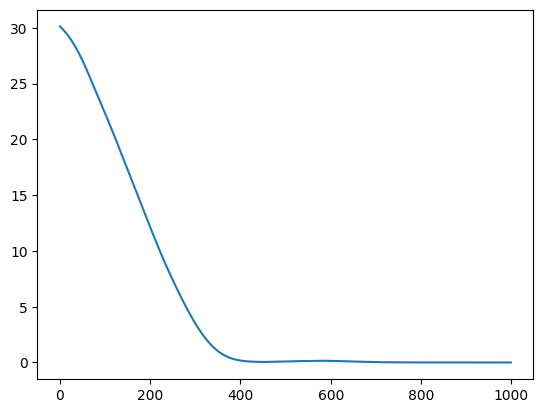

In [90]:
plt.plot(np.real(np.array(unitary_scores)))

In [91]:
unitary_scores[-1]

(0.0018932707629986112-3.3306690738754696e-15j)

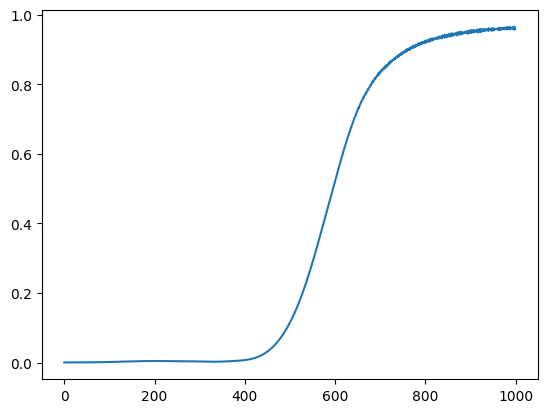

In [92]:
plt.plot(overlaps)

In [93]:
overlaps[-1]

0.95802728405803

# Sweep

In [58]:
num_sites = 6

In [59]:
unitarity_learning_rate = 1
overlap_learning_rate = 50

adam_params = (1e-3, 0.4, 0.4)

In [60]:
num_iterations = 1500

In [61]:
bond_dimension=5

In [62]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [63]:
triv_proj_rep_solutions = dict()
triv_proj_rep_unitarity_scores = dict()
triv_proj_rep_overlap_scores = dict()

for k, c in cases_triv_proj_rep.items():
    start = time.time()
    print(k)

    if (k[2] != 0):
        (
            left_mpo_tensors,
            right_mpo_tensors,
            left_b_tensors,
            right_b_tensors,
            left_total_dimension,
            right_total_dimension,
            unitarity_learning_rate,
            overlap_learning_rate,
            symmetry_transfer_matrix,
            left_adam_optimizers,
            right_adam_optimizers
        ) = initialize_optimization(
            num_sites,
            bond_dimension,
            c,
            unitarity_learning_rate,
            overlap_learning_rate,
            adam_params
        )

        current_unitarity_scores = list()
        current_overlap_scores = list()

        for _ in range(num_iterations):
            unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
                left_mpo_tensors,
                right_mpo_tensors,
                left_b_tensors,
                right_b_tensors,
                left_total_dimension,
                right_total_dimension,
                unitarity_learning_rate,
                overlap_learning_rate,
                symmetry_transfer_matrix,
                left_adam_optimizers,
                right_adam_optimizers
            )
        
            current_unitarity_scores.append(unitarity)
            current_overlap_scores.append(overlap)

        triv_proj_rep_solutions[k] = (left_mpo_tensors, right_mpo_tensors)
        triv_proj_rep_unitarity_scores[k] = current_unitarity_scores
        triv_proj_rep_overlap_scores[k] = current_overlap_scores


    end = time.time()
    print(end - start)

(0.65, 0, 0)
4.1961669921875e-05
(0.65, 0, 1)
146.2056121826172
(0.65, 0, 2)
150.9118776321411
(0.65, 0, 3)
148.82617115974426
(0.65, 1, 0)
1.1205673217773438e-05
(0.65, 1, 1)
154.90247917175293
(0.65, 1, 2)
148.1977379322052
(0.65, 1, 3)
143.22358083724976
(0.45, 0, 0)
1.1920928955078125e-05
(0.45, 0, 1)
163.26331496238708
(0.45, 0, 2)
170.42251443862915
(0.45, 0, 3)
178.10675263404846
(0.45, 1, 0)
1.1205673217773438e-05
(0.45, 1, 1)
150.63349533081055
(0.45, 1, 2)
139.31725907325745
(0.45, 1, 3)
139.2108085155487
(0.55, 0, 0)
1.239776611328125e-05
(0.55, 0, 1)
140.43055486679077
(0.55, 0, 2)
142.83121013641357
(0.55, 0, 3)
139.24177026748657
(0.55, 1, 0)
1.0967254638671875e-05
(0.55, 1, 1)
139.06914973258972
(0.55, 1, 2)
139.76783442497253
(0.55, 1, 3)
139.45058822631836
(0.95, 0, 0)
1.1444091796875e-05
(0.95, 0, 1)
140.4864547252655
(0.95, 0, 2)
140.2944633960724
(0.95, 0, 3)
139.73155641555786
(0.95, 1, 0)
1.1205673217773438e-05
(0.95, 1, 1)
140.12160873413086
(0.95, 1, 2)
139.9397

In [64]:
non_triv_proj_rep_solutions = dict()
non_triv_proj_rep_unitarity_scores = dict()
non_triv_proj_rep_overlap_scores = dict()

for k, c in cases_non_triv_proj_rep.items():
    start = time.time()
    print(k)

    if (k[2] != 0):
        (
            left_mpo_tensors,
            right_mpo_tensors,
            left_b_tensors,
            right_b_tensors,
            left_total_dimension,
            right_total_dimension,
            unitarity_learning_rate,
            overlap_learning_rate,
            symmetry_transfer_matrix,
            left_adam_optimizers,
            right_adam_optimizers
        ) = initialize_optimization(
            num_sites,
            bond_dimension,
            c,
            unitarity_learning_rate,
            overlap_learning_rate,
            adam_params
        )

        current_unitarity_scores = list()
        current_overlap_scores = list()

        for _ in range(num_iterations):
            unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
                left_mpo_tensors,
                right_mpo_tensors,
                left_b_tensors,
                right_b_tensors,
                left_total_dimension,
                right_total_dimension,
                unitarity_learning_rate,
                overlap_learning_rate,
                symmetry_transfer_matrix,
                left_adam_optimizers,
                right_adam_optimizers
            )
        
            current_unitarity_scores.append(unitarity)
            current_overlap_scores.append(overlap)

        non_triv_proj_rep_solutions[k] = (left_mpo_tensors, right_mpo_tensors)
        non_triv_proj_rep_unitarity_scores[k] = current_unitarity_scores
        non_triv_proj_rep_overlap_scores[k] = current_overlap_scores


    end = time.time()
    print(end - start)

(0.65, 0, 0)
0.00023102760314941406
(0.65, 0, 1)
137.21232438087463
(0.65, 0, 2)
138.29249954223633
(0.65, 0, 3)
136.98489832878113
(0.65, 1, 0)
1.1444091796875e-05
(0.65, 1, 1)
136.95643424987793
(0.65, 1, 2)
136.87366819381714
(0.65, 1, 3)
137.2181260585785
(0.45, 0, 0)
1.1682510375976562e-05
(0.45, 0, 1)
137.0842878818512
(0.45, 0, 2)
137.84367680549622
(0.45, 0, 3)
137.47376441955566
(0.45, 1, 0)
1.1444091796875e-05
(0.45, 1, 1)
137.05614185333252
(0.45, 1, 2)
137.57502436637878
(0.45, 1, 3)
137.3844530582428
(0.55, 0, 0)
1.1920928955078125e-05
(0.55, 0, 1)
136.8522653579712
(0.55, 0, 2)
137.5411787033081
(0.55, 0, 3)
137.2648811340332
(0.55, 1, 0)
1.1682510375976562e-05
(0.55, 1, 1)
137.22489738464355
(0.55, 1, 2)
137.20309710502625
(0.55, 1, 3)
137.0417675971985
(0.95, 0, 0)
1.0967254638671875e-05
(0.95, 0, 1)
136.75718879699707
(0.95, 0, 2)
136.97458815574646
(0.95, 0, 3)
136.69903326034546
(0.95, 1, 0)
1.1205673217773438e-05
(0.95, 1, 1)
137.15268230438232
(0.95, 1, 2)
137.0909

In [67]:
with open(r'solutions/non_trivial_models_non_triv_proj_rep_mpo_sol.pkl', 'wb') as file:
    to_save ={
        'solutions': non_triv_proj_rep_solutions,
        'unitarity_scores': non_triv_proj_rep_unitarity_scores,
        'overlaps': non_triv_proj_rep_overlap_scores
    }
    pickle.dump(to_save, file)

In [68]:
with open(r'solutions/non_trivial_models_triv_proj_rep_mpo_sol.pkl', 'wb') as file:
    to_save ={
        'solutions': triv_proj_rep_solutions,
        'unitarity_scores': triv_proj_rep_unitarity_scores,
        'overlaps': triv_proj_rep_overlap_scores
    }
    pickle.dump(to_save, file)

In [12]:
with open(r'solutions/non_trivial_models_non_triv_proj_rep_mpo_sol.pkl', 'rb') as file:
    dict_non_triv = pickle.load(file)

with open(r'solutions/non_trivial_models_triv_proj_rep_mpo_sol.pkl', 'rb') as file:
    dict_triv = pickle.load(file)

In [13]:
ud = dict_triv['unitarity_scores']

In [14]:
X = np.array(list(ud.values()))

In [15]:
X = np.real(X)

In [16]:
pd.Series(X[:, -1]).describe()

count    126.000000
mean       0.253978
std        0.909945
min        0.005366
25%        0.055299
50%        0.093761
75%        0.151732
max        9.565872
dtype: float64

In [17]:
od = dict_triv['overlaps']

In [18]:
X = np.array(list(od.values()))

In [19]:
pd.Series(X[:, -1]).describe()

count    1.260000e+02
mean     8.304738e-01
std      3.615750e-01
min      1.591008e-09
25%      9.591523e-01
50%      9.862221e-01
75%      9.990895e-01
max      1.011344e+00
dtype: float64

In [20]:
od = dict_non_triv['overlaps']

In [21]:
X = np.array(list(od.values()))

In [22]:
pd.Series(X[:, -1]).describe()

count    1.260000e+02
mean     3.702586e-01
std      4.566300e-01
min      3.182446e-09
25%      2.898559e-04
50%      1.946383e-03
75%      9.427014e-01
max      9.994458e-01
dtype: float64

Might need to re-do non-triv...

Check scores:

In [23]:
non_triv_proj_rep_unitarity_scores_array = np.array(list(dict_non_triv['unitarity_scores'].values()))

In [24]:
non_triv_proj_rep_unitarity_scores_array.shape

(126, 1500)

In [25]:
np.max(np.abs(np.imag(non_triv_proj_rep_unitarity_scores_array)))

1.1084466677857563e-10

In [26]:
non_triv_proj_rep_unitarity_scores_array = np.real(non_triv_proj_rep_unitarity_scores_array)

In [27]:
pd.Series(non_triv_proj_rep_unitarity_scores_array[:, -1]).describe()

count    126.000000
mean       2.465665
std       10.577191
min        0.013195
25%        0.056542
50%        0.093064
75%        0.208726
max       84.625461
dtype: float64

In [28]:
np.argmax(non_triv_proj_rep_unitarity_scores_array[:, -1])

18

In [32]:
worst_unitary_scores_key = list(dict_non_triv['unitarity_scores'].keys())[18]
worst_unitary_scores = dict_non_triv['unitarity_scores'][worst_unitary_scores_key]

In [33]:
worst_unitary_scores_key

(0.95, 0, 1)

/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


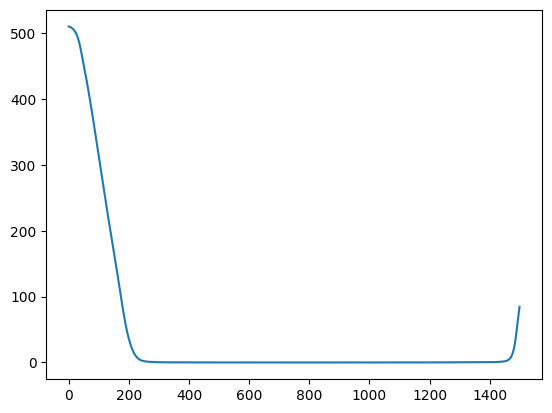

In [34]:
plt.plot(worst_unitary_scores)
#plt.semilogy('log')

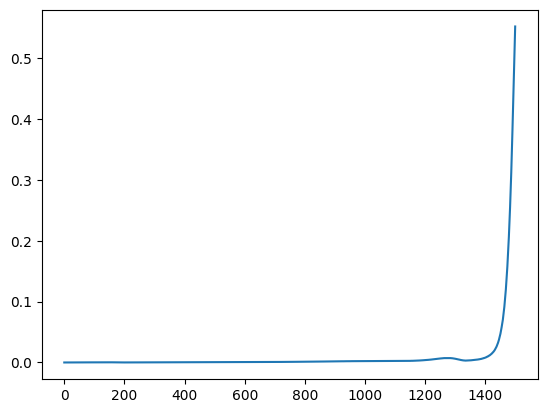

In [35]:
plt.plot(dict_non_triv['overlaps'][worst_unitary_scores_key])

In [36]:
non_triv_proj_rep_overlap_scores_array = np.array(list(dict_non_triv['overlaps'].values()))

In [37]:
non_triv_proj_rep_overlap_scores_array.shape

(126, 1500)

In [38]:
pd.Series(non_triv_proj_rep_overlap_scores_array[:, -1]).describe()

count    1.260000e+02
mean     3.702586e-01
std      4.566300e-01
min      3.182446e-09
25%      2.898559e-04
50%      1.946383e-03
75%      9.427014e-01
max      9.994458e-01
dtype: float64

In [39]:
np.argmin(non_triv_proj_rep_overlap_scores_array[:, -1])

120

In [40]:
worst_overlap_scores_key = list(dict_non_triv['overlaps'].keys())[120]
worst_overlap_scores = dict_non_triv['overlaps'][worst_overlap_scores_key]

In [41]:
worst_overlap_scores_key

(0.5, 0, 1)

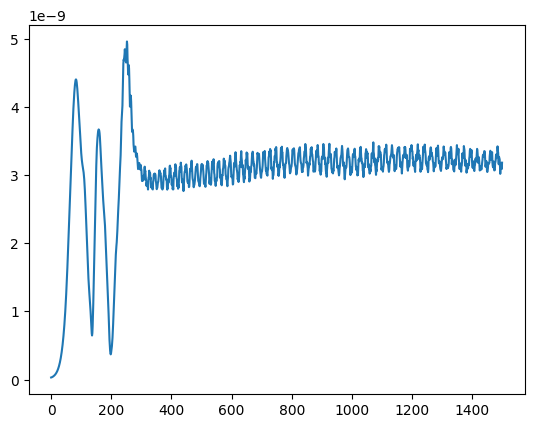

In [42]:
plt.plot(worst_overlap_scores)
#plt.semilogy('log')

/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


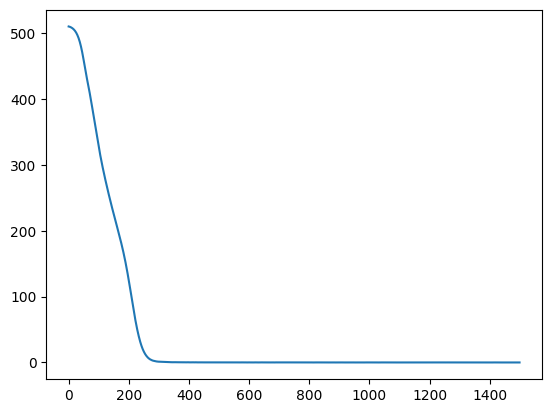

In [44]:
plt.plot(dict_non_triv['unitarity_scores'][worst_overlap_scores_key])

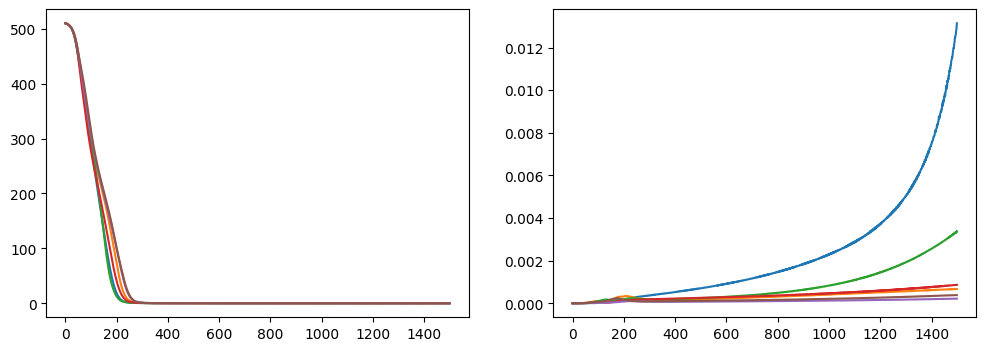

In [236]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0

for i in range(2):
    for j in range(1, 4):
        key = (t, i, j)
        ax1.plot(dict_non_triv['unitarity_scores'][key])
        ax2.plot(dict_non_triv['overlaps'][key])

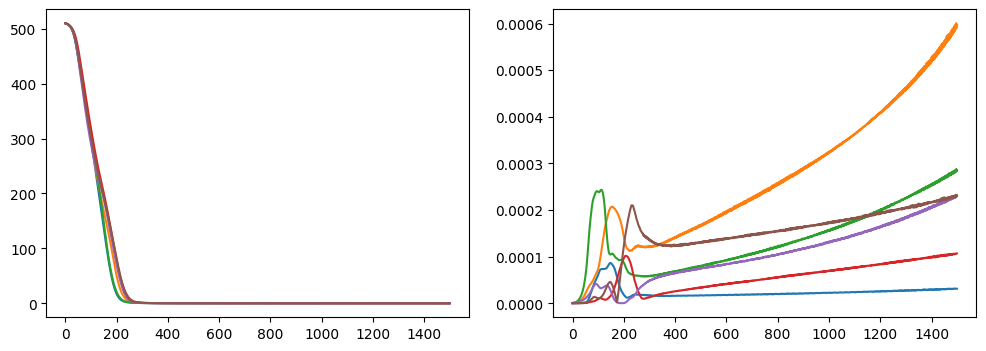

In [54]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.3

for i in range(2):
    for j in range(1, 4):
        key = (t, i, j)
        ax1.plot(dict_non_triv['unitarity_scores'][key])
        ax2.plot(dict_non_triv['overlaps'][key])

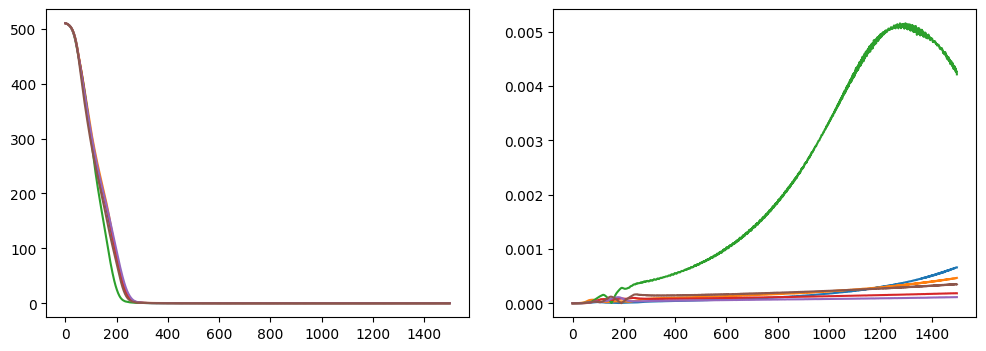

In [53]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.35

for i in range(2):
    for j in range(1, 4):
        key = (t, i, j)
        ax1.plot(dict_non_triv['unitarity_scores'][key])
        ax2.plot(dict_non_triv['overlaps'][key])

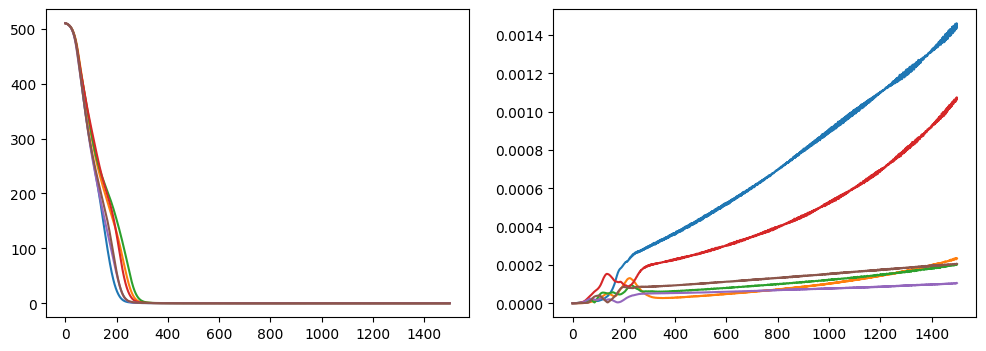

In [52]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.4

for i in range(2):
    for j in range(1, 4):
        key = (t, i, j)
        ax1.plot(dict_non_triv['unitarity_scores'][key])
        ax2.plot(dict_non_triv['overlaps'][key])

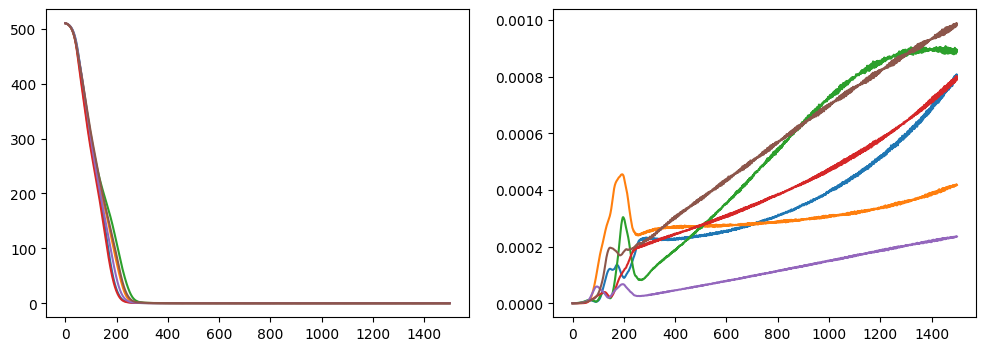

In [51]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.45

for i in range(2):
    for j in range(1, 4):
        key = (t, i, j)
        ax1.plot(dict_non_triv['unitarity_scores'][key])
        ax2.plot(dict_non_triv['overlaps'][key])

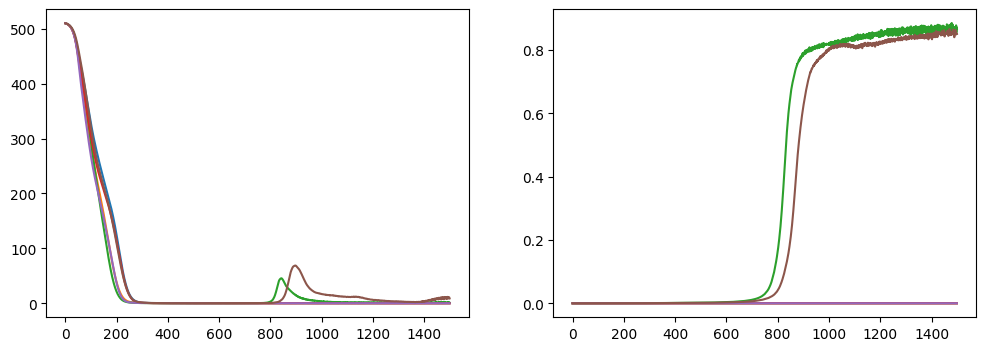

In [50]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.5

for i in range(2):
    for j in range(1, 4):
        key = (t, i, j)
        ax1.plot(dict_non_triv['unitarity_scores'][key])
        ax2.plot(dict_non_triv['overlaps'][key])

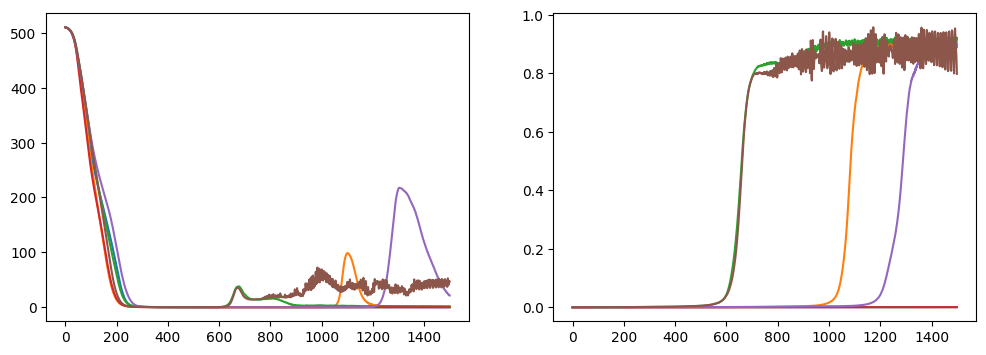

In [46]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.55

for i in range(2):
    for j in range(1, 4):
        key = (t, i, j)
        ax1.plot(dict_non_triv['unitarity_scores'][key])
        ax2.plot(dict_non_triv['overlaps'][key])

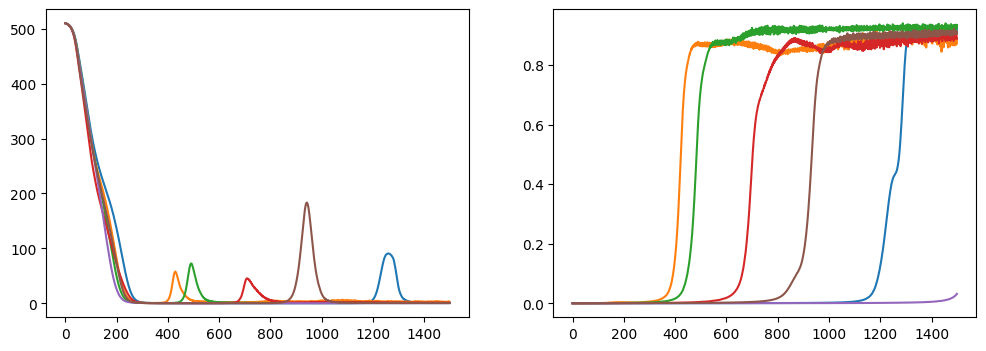

In [47]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.6

for i in range(2):
    for j in range(1, 4):
        key = (t, i, j)
        ax1.plot(dict_non_triv['unitarity_scores'][key])
        ax2.plot(dict_non_triv['overlaps'][key])

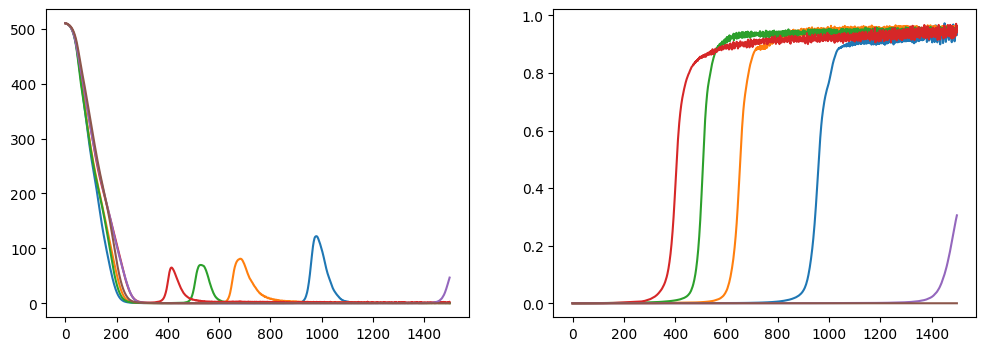

In [48]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.65

for i in range(2):
    for j in range(1, 4):
        key = (t, i, j)
        ax1.plot(dict_non_triv['unitarity_scores'][key])
        ax2.plot(dict_non_triv['overlaps'][key])

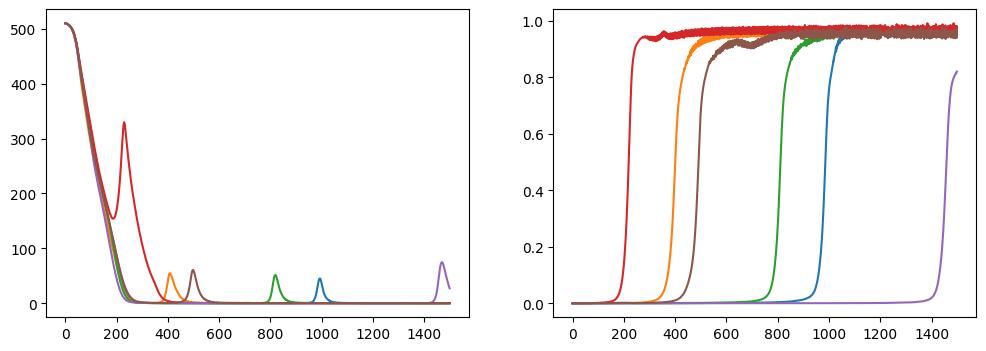

In [49]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.7

for i in range(2):
    for j in range(1, 4):
        key = (t, i, j)
        ax1.plot(dict_non_triv['unitarity_scores'][key])
        ax2.plot(dict_non_triv['overlaps'][key])

Take subcase, find nice hyperparameters.

## Check hyperparameters

In [149]:
sub_case = cases_non_triv_proj_rep[(0.4, 0, 1)]

In [150]:
num_sites = 6

In [151]:
unitarity_learning_rate = 1
overlap_learning_rate = 100

adam_params = (1e-3, 0.4, 0.4)

In [152]:
num_iterations = 2500

In [153]:
bond_dimension=5

In [154]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [155]:
c = sub_case

start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    c,
    unitarity_learning_rate,
    overlap_learning_rate,
    adam_params
)

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

249.82734775543213


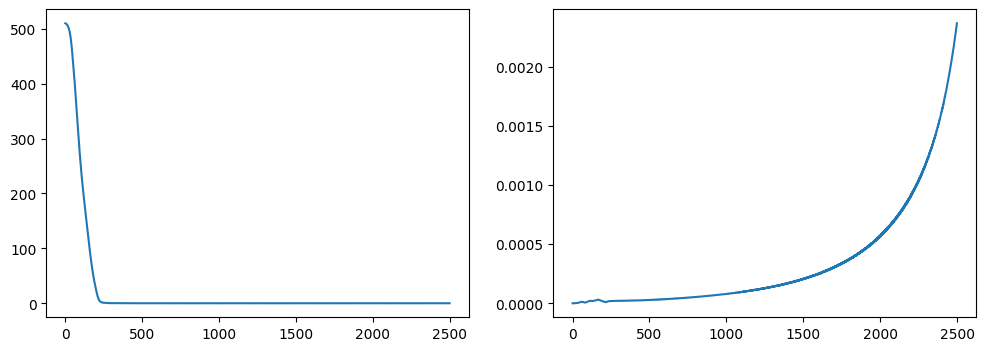

In [156]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

In [157]:
(current_unitarity_scores[-1], current_overlap_scores[-1])

((0.06332302890450592-3.907985046680551e-14j), 0.002365949438274961)

In [125]:
unitarity_learning_rate = 1
overlap_learning_rate = 200

adam_params = (3e-3, 0.4, 0.4)

In [126]:
num_iterations = 1500

In [127]:
bond_dimension=5

In [128]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [129]:
c = sub_case

start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    c,
    unitarity_learning_rate,
    overlap_learning_rate,
    adam_params
)

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

148.87794137001038


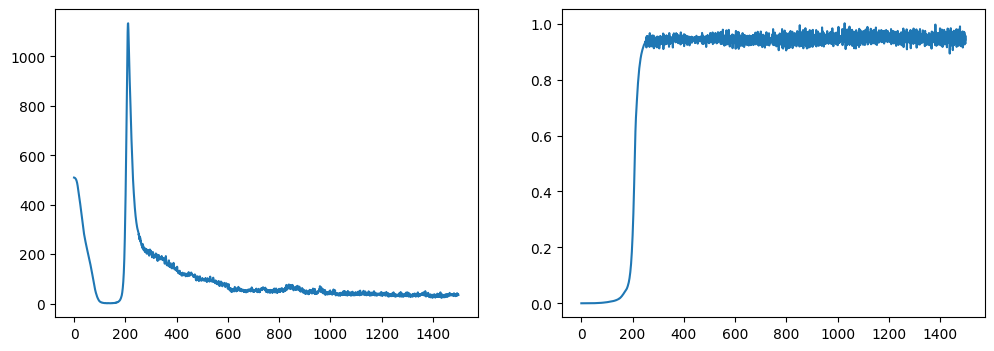

In [130]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

In [131]:
current_overlap_scores[-1]

0.9315248665529321

In [132]:
current_unitarity_scores[-1]

(35.257445078293586-4.796163466380676e-13j)

Threshold

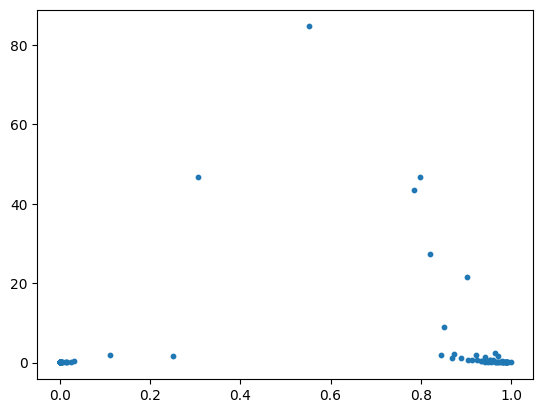

In [162]:
plt.scatter(
    non_triv_proj_rep_overlap_scores_array[:, -1],
    non_triv_proj_rep_unitarity_scores_array[:, -1],
    s=10
)

Pick up previous solutions, keep running to improve accuracy.

In [163]:
unitary_score_threshold=1
overlap_score_threshold = 0.9

In [166]:
dict_non_triv['solutions'][(0, 0, 1)]

([<npc.Array shape=(2, 2, 5) labels=['p', 'p*', 'vR']>,
  <npc.Array shape=(4, 4, 5, 5) labels=['p', 'p*', 'vL', 'vR']>,
  <npc.Array shape=(2, 2, 5, 5) labels=['p', 'p*', 'vL', 'vR']>,
  <npc.Array shape=(4, 4, 5, 5) labels=['p', 'p*', 'vL', 'vR']>,
  <npc.Array shape=(2, 2, 5, 5) labels=['p', 'p*', 'vL', 'vR']>,
  <npc.Array shape=(4, 4, 5) labels=['p', 'p*', 'vL']>],
 [<npc.Array shape=(4, 4, 5) labels=['p', 'p*', 'vR']>,
  <npc.Array shape=(2, 2, 5, 5) labels=['p', 'p*', 'vL', 'vR']>,
  <npc.Array shape=(4, 4, 5, 5) labels=['p', 'p*', 'vL', 'vR']>,
  <npc.Array shape=(2, 2, 5, 5) labels=['p', 'p*', 'vL', 'vR']>,
  <npc.Array shape=(4, 4, 5, 5) labels=['p', 'p*', 'vL', 'vR']>,
  <npc.Array shape=(2, 2, 5) labels=['p', 'p*', 'vL']>])

In [173]:
num_iterations=1e4

In [174]:
non_triv_proj_rep_solutions = dict()
non_triv_proj_rep_unitarity_scores = dict()
non_triv_proj_rep_overlap_scores = dict()

for k, c in cases_non_triv_proj_rep.items():
    start = time.time()
    print(k)

    if (k[2] != 0):
        (
            left_mpo_tensors,
            right_mpo_tensors,
            left_b_tensors,
            right_b_tensors,
            left_total_dimension,
            right_total_dimension,
            unitarity_learning_rate,
            overlap_learning_rate,
            symmetry_transfer_matrix,
            left_adam_optimizers,
            right_adam_optimizers
        ) = initialize_optimization(
            num_sites,
            bond_dimension,
            c,
            unitarity_learning_rate,
            overlap_learning_rate,
            adam_params
        )
        
        current_unitarity_scores = list()
        current_overlap_scores = list()

        iteration_number = 0
        break_condition = True
        while break_condition:
            unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
                left_mpo_tensors,
                right_mpo_tensors,
                left_b_tensors,
                right_b_tensors,
                left_total_dimension,
                right_total_dimension,
                unitarity_learning_rate,
                overlap_learning_rate,
                symmetry_transfer_matrix,
                left_adam_optimizers,
                right_adam_optimizers
            )

            current_unitarity_scores.append(unitarity)
            current_overlap_scores.append(overlap)

            unitary_condition = (unitarity < unitary_score_threshold)
            overlap_condition = (overlap > overlap_score_threshold)
            score_condition = (unitary_condition and overlap_condition)
            iteration_number += 1
            iteration_condition = (iteration_number > num_iterations)

            break_condition = not (iteration_condition or score_condition)

        non_triv_proj_rep_solutions[k] = (left_mpo_tensors, right_mpo_tensors)
        non_triv_proj_rep_unitarity_scores[k] = current_unitarity_scores
        non_triv_proj_rep_overlap_scores[k] = current_overlap_scores

    end = time.time()
    print(end - start)

(0.65, 0, 0)
6.246566772460938e-05
(0.65, 0, 1)
49.776825189590454
(0.65, 0, 2)
83.72937345504761
(0.65, 0, 3)
101.59211874008179
(0.65, 1, 0)
1.1920928955078125e-05
(0.65, 1, 1)
44.251593828201294
(0.65, 1, 2)
178.12373876571655
(0.65, 1, 3)
46.66535568237305
(0.45, 0, 0)
1.1682510375976562e-05
(0.45, 0, 1)
963.4305601119995
(0.45, 0, 2)
1023.0032358169556
(0.45, 0, 3)
936.6811971664429
(0.45, 1, 0)
1.1205673217773438e-05
(0.45, 1, 1)
924.8405480384827
(0.45, 1, 2)


KeyboardInterrupt: 

In [175]:
non_triv_proj_rep_overlap_scores.keys()

dict_keys([(0.65, 0, 1), (0.65, 0, 2), (0.65, 0, 3), (0.65, 1, 1), (0.65, 1, 2), (0.65, 1, 3), (0.45, 0, 1), (0.45, 0, 2), (0.45, 0, 3), (0.45, 1, 1)])

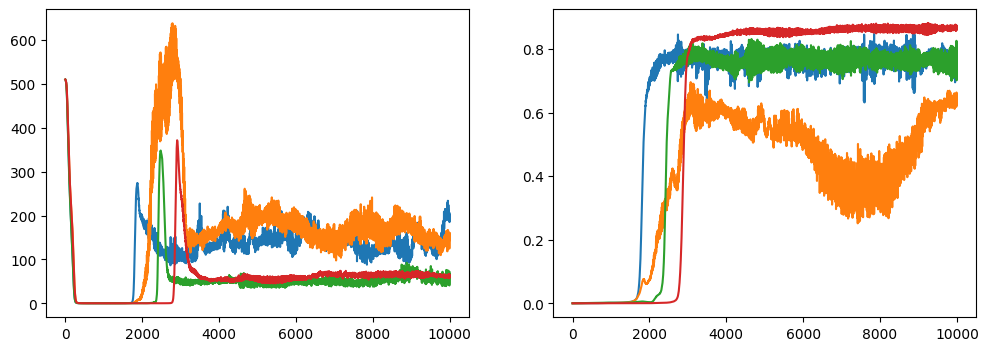

In [177]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.7

for k in non_triv_proj_rep_overlap_scores:
    if k[0] == 0.45:
        ax1.plot(non_triv_proj_rep_unitarity_scores[k])
        ax2.plot(non_triv_proj_rep_overlap_scores[k])

# Test hyperparameters... again

In [178]:
sub_case = cases_non_triv_proj_rep[(0.45, 0, 1)]

In [179]:
num_sites = 6

In [180]:
unitarity_learning_rate = 1
overlap_learning_rate = 100

adam_params = (1e-3, 0.4, 0.4)

In [181]:
num_iterations = 1000

In [182]:
bond_dimension=5

In [183]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [184]:
c = sub_case

start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    c,
    unitarity_learning_rate,
    overlap_learning_rate,
    adam_params
)

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

105.40344548225403


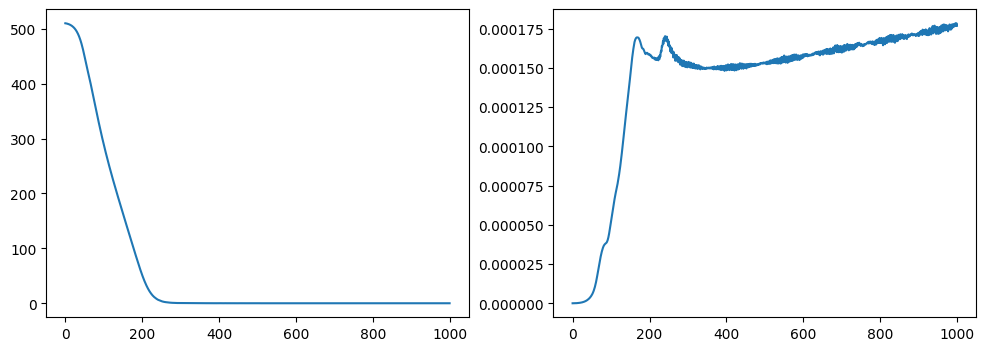

In [185]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

In [192]:
unitarity_learning_rate = 1
overlap_learning_rate = 100

adam_params = (3e-4, 0.4, 0.4)

In [202]:
num_iterations = int(1e4)

In [203]:
bond_dimension=5

In [204]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [205]:
c = sub_case

start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    c,
    unitarity_learning_rate,
    overlap_learning_rate,
    adam_params
)

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

1037.9288330078125


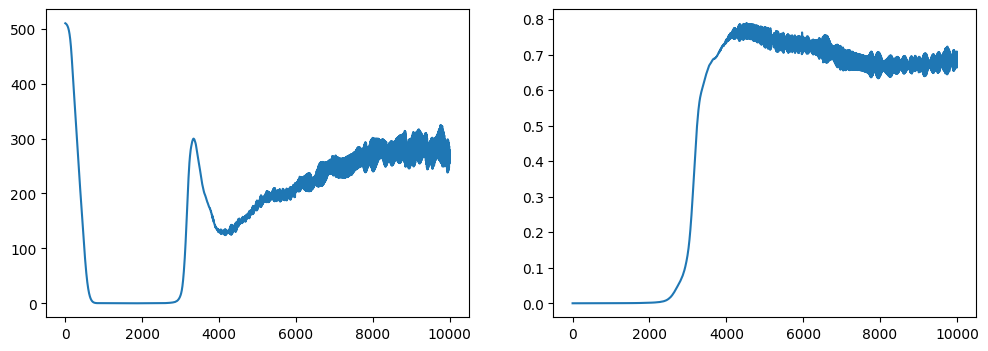

In [206]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

In [207]:
unitarity_learning_rate = 1
overlap_learning_rate =20

adam_params = (3e-4, 0.4, 0.4)

In [208]:
num_iterations = int(1e4)

In [209]:
bond_dimension=5

In [210]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [211]:
num_sites=4

In [212]:
c = sub_case

start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    c,
    unitarity_learning_rate,
    overlap_learning_rate,
    adam_params
)

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

632.2346215248108


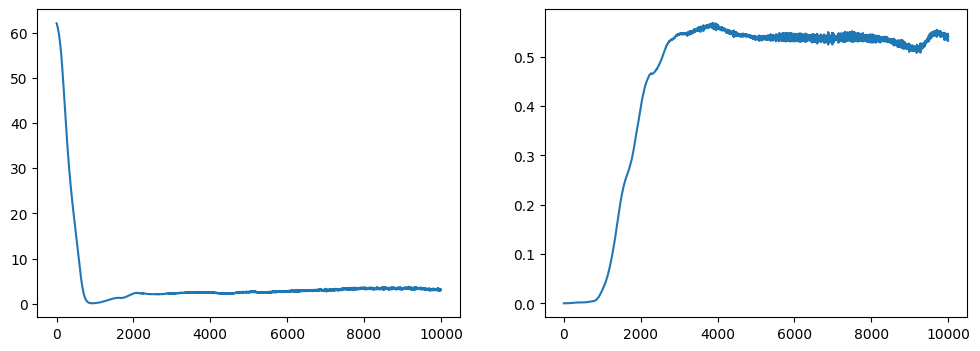

In [213]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

Not great...

In [214]:
unitarity_learning_rate = 1
overlap_learning_rate = 100

adam_params = (3e-4, 0.4, 0.4)

In [215]:
num_iterations = int(5000)

In [217]:
bond_dimension=8

In [219]:
num_sites=6

In [220]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [221]:
c = sub_case

start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    c,
    unitarity_learning_rate,
    overlap_learning_rate,
    adam_params
)

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

694.0090668201447


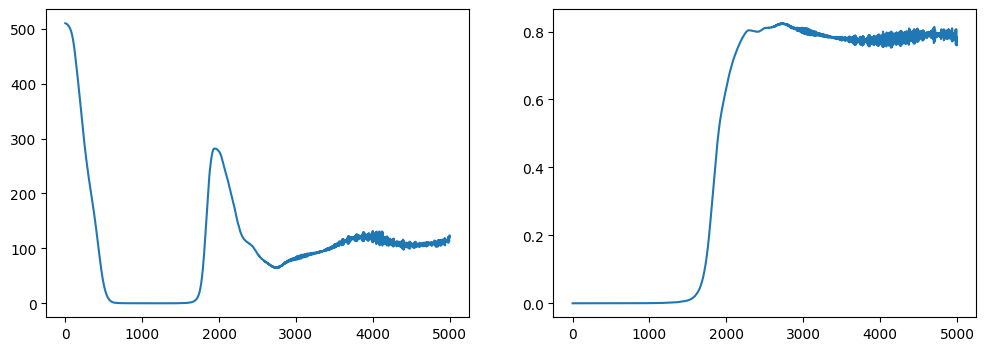

In [222]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

In [223]:
unitarity_learning_rate = 1
overlap_learning_rate = 30

adam_params = (5e-4, 0.4, 0.4)

In [230]:
num_iterations = int(1e4)

In [231]:
bond_dimension=5

In [232]:
num_sites=6

In [233]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [234]:
c = sub_case

start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    c,
    unitarity_learning_rate,
    overlap_learning_rate,
    adam_params
)

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

1018.1744706630707


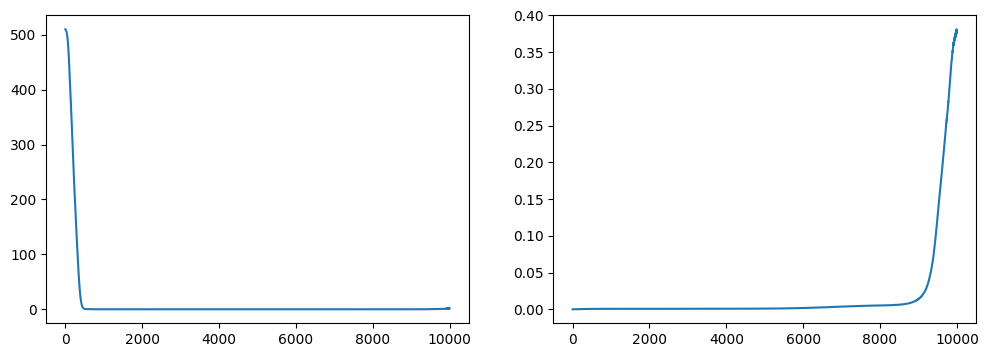

In [235]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

In [246]:
unitarity_learning_rate = 1
overlap_learning_rate = 150

adam_params = (1e-3, 0.4, 0.4)

In [247]:
num_iterations = int(1500)

In [248]:
bond_dimension=5

In [249]:
num_sites=6

In [250]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [251]:
c = sub_case

start = time.time()

(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    left_total_dimension,
    right_total_dimension,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(
    num_sites,
    bond_dimension,
    c,
    unitarity_learning_rate,
    overlap_learning_rate,
    adam_params
)

current_unitarity_scores = list()
current_overlap_scores = list()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

155.00922775268555


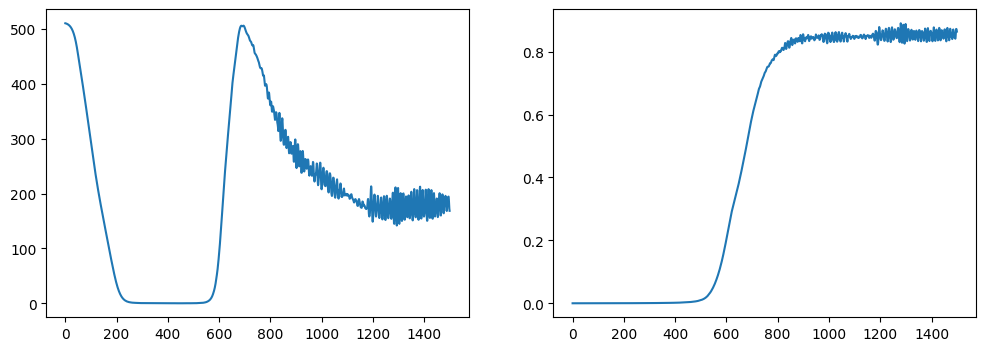

In [252]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

In [253]:
c = sub_case

unitarity_learning_rate = 1
overlap_learning_rate = 100

start = time.time()

for _ in range(num_iterations):
    unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    current_unitarity_scores.append(unitarity)
    current_overlap_scores.append(overlap)

end = time.time()
print(end - start)

152.2671513557434


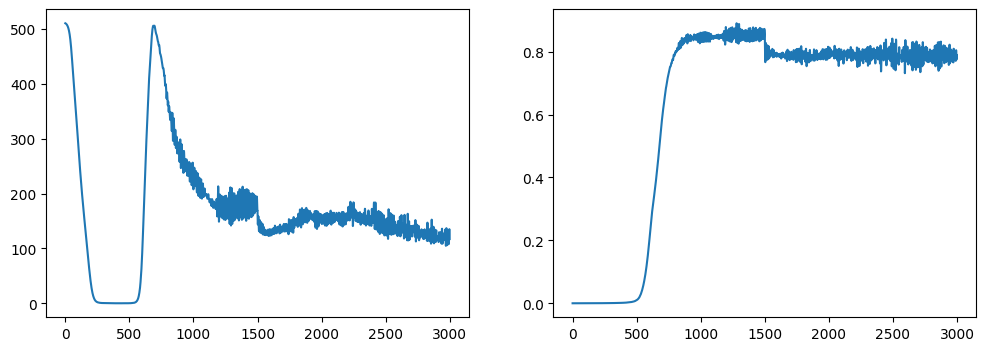

In [254]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

ax1.plot(current_unitarity_scores)
ax2.plot(current_overlap_scores)

Random intialization.

Just try it again and again. (Should really try different parameters too.)

In [270]:
unitarity_learning_rate = 1
overlap_learning_rate = 50

adam_params = (1e-3, 0.4, 0.4)

In [271]:
num_iterations = int(3000)
num_seeds = 20

In [272]:
bond_dimension=5

In [273]:
num_sites=6

In [274]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [275]:
unitary_scores = list()
overlap_scores = list()

for i in range(num_seeds):
    print(i)

    c = sub_case
    
    start = time.time()
    
    (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    ) = initialize_optimization(
        num_sites,
        bond_dimension,
        c,
        unitarity_learning_rate,
        overlap_learning_rate,
        adam_params
    )
    
    current_unitarity_scores = list()
    current_overlap_scores = list()
    
    for _ in range(num_iterations):
        unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
            left_mpo_tensors,
            right_mpo_tensors,
            left_b_tensors,
            right_b_tensors,
            left_total_dimension,
            right_total_dimension,
            unitarity_learning_rate,
            overlap_learning_rate,
            symmetry_transfer_matrix,
            left_adam_optimizers,
            right_adam_optimizers
        )
    
        current_unitarity_scores.append(unitarity)
        current_overlap_scores.append(overlap)

    unitary_scores.append(current_unitarity_scores)
    overlap_scores.append(current_overlap_scores)
    
    end = time.time()
    print(end - start)

0
286.92530393600464
1
284.047078371048
2
283.41417813301086
3
285.0168926715851
4
284.1971547603607
5
284.35815262794495
6
285.75098037719727
7
284.6831223964691
8
283.77567958831787
9
284.63952112197876
10
284.8100037574768
11
283.6698558330536
12
284.5370571613312
13
285.0072066783905
14
284.6426956653595
15
283.7151575088501
16
282.978755235672
17
283.48652386665344
18
304.75833344459534
19
324.46766233444214


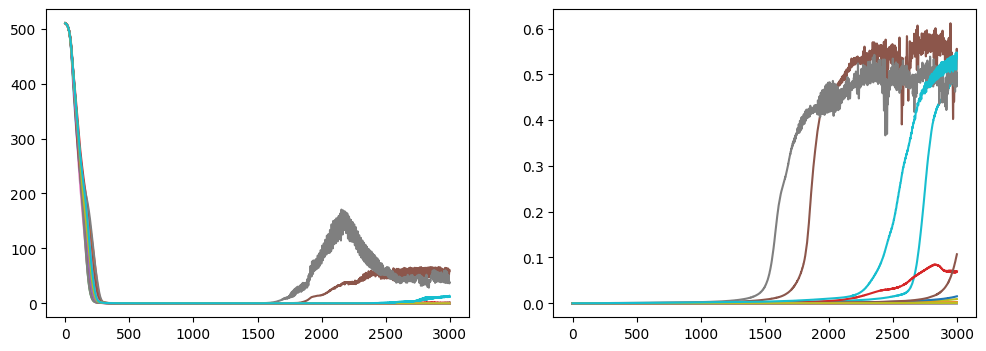

In [276]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

t = 0.7

for l1, l2 in zip(unitary_scores, overlap_scores):
    ax1.plot(l1)
    ax2.plot(l2)

In [291]:
unitarity_learning_rate = 1
overlap_learning_rate = 200

adam_params = (5e-4, 0.4, 0.4)

In [292]:
num_iterations = int(1e4)
num_seeds = 5

In [293]:
bond_dimension=5

In [294]:
num_sites=6

In [295]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [296]:
unitary_scores = list()
overlap_scores = list()

for i in range(num_seeds):
    print(i)

    c = sub_case
    
    start = time.time()
    
    (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    ) = initialize_optimization(
        num_sites,
        bond_dimension,
        c,
        unitarity_learning_rate,
        overlap_learning_rate,
        adam_params
    )
    
    current_unitarity_scores = list()
    current_overlap_scores = list()
    
    for _ in range(num_iterations):
        unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
            left_mpo_tensors,
            right_mpo_tensors,
            left_b_tensors,
            right_b_tensors,
            left_total_dimension,
            right_total_dimension,
            unitarity_learning_rate,
            overlap_learning_rate,
            symmetry_transfer_matrix,
            left_adam_optimizers,
            right_adam_optimizers
        )
    
        current_unitarity_scores.append(unitarity)
        current_overlap_scores.append(overlap)

    unitary_scores.append(current_unitarity_scores)
    overlap_scores.append(current_overlap_scores)
    
    end = time.time()
    print(end - start)

0
948.0707654953003
1
941.8676495552063
2
942.1173634529114
3
938.705169916153
4
943.2657687664032


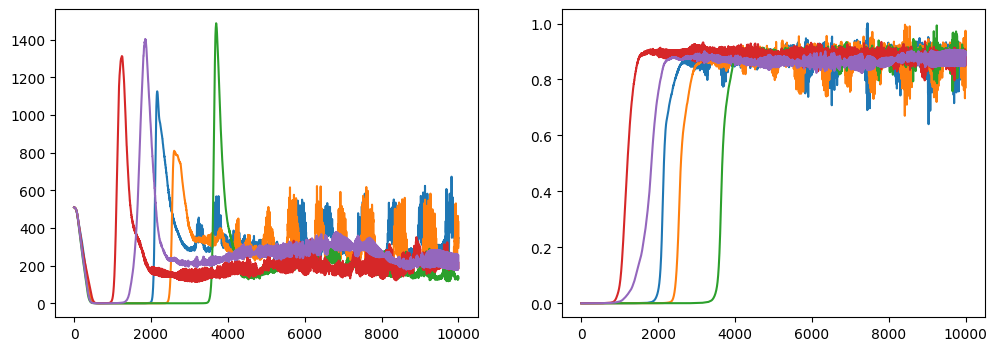

In [297]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 4))

for l1, l2 in zip(unitary_scores, overlap_scores):
    ax1.plot(l1)
    ax2.plot(l2)

In [255]:
unitarity_learning_rate = 1
overlap_learning_rate = 150

adam_params = (1e-3, 0.4, 0.4)

In [260]:
num_iterations = int(1500)
num_seeds = 10

In [257]:
bond_dimension=5

In [258]:
num_sites=6

In [259]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [261]:
unitary_scores = list()
overlap_scores = list()

for i in range(num_seeds):
    print(i)

    c = sub_case
    
    start = time.time()
    
    (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    ) = initialize_optimization(
        num_sites,
        bond_dimension,
        c,
        unitarity_learning_rate,
        overlap_learning_rate,
        adam_params
    )
    
    current_unitarity_scores = list()
    current_overlap_scores = list()
    
    for _ in range(num_iterations):
        unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
            left_mpo_tensors,
            right_mpo_tensors,
            left_b_tensors,
            right_b_tensors,
            left_total_dimension,
            right_total_dimension,
            unitarity_learning_rate,
            overlap_learning_rate,
            symmetry_transfer_matrix,
            left_adam_optimizers,
            right_adam_optimizers
        )
    
        current_unitarity_scores.append(unitarity)
        current_overlap_scores.append(overlap)

    unitary_scores.append(current_unitarity_scores)
    overlap_scores.append(current_overlap_scores)
    
    end = time.time()
    print(end - start)

0
157.3620252609253
1
150.4941601753235
2
148.9256660938263
3
152.763085603714
4
155.41069674491882
5
154.1145625114441
6
170.17206287384033
7
181.98829126358032
8
175.631854057312
9
161.44087767601013


In [151]:
right_phases = list()

for l_c, l_s in zip(cases, solutions):

    solutions.append(list())

    solutions_dict = {
        v: k[1] for v, k in zip(symmetry_labels[1:], l_s)
    }

    b_tensors = [
        l_c[0].psi.get_B(i)
        for i in range(l_c[0].right_symmetry_index + 1, l_c[0].right_symmetry_index + 1 + num_sites)
    ]

    current_phases = [
        proj_rep_phase(
            l_c[0].right_projected_symmetry_state,
            b_tensors,
            solutions_dict[l1],
            solutions_dict[l2],
            solutions_dict[l3],
        )
        for l1, l2, l3 in group_products
    ]

    right_phases.append(current_phases)

In [152]:
phases_array = np.array(right_phases)

In [153]:
gauge_invariant_phases = phases_array[:,::2]/phases_array[:,1::2]

In [154]:
np.round(gauge_invariant_phases, 3)

array([[-0.999-4.000e-03j, -0.999-4.000e-03j, -1.   -3.000e-03j],
       [-1.   -0.000e+00j, -1.   +1.000e-03j, -1.   +0.000e+00j],
       [-0.997+2.000e-03j, -1.   -0.000e+00j, -0.995+2.000e-03j],
       [-1.005-8.000e-03j, -0.998+9.000e-03j, -0.998+3.200e-02j],
       [-0.941+8.000e-03j, -0.998+1.000e-03j, -0.946+9.000e-03j],
       [-1.027-5.800e-02j, -1.022+5.000e-03j, -0.883+2.100e-02j],
       [-0.999-0.000e+00j, -0.999-2.000e-03j, -1.001+0.000e+00j],
       [-0.998+7.000e-03j, -1.005+7.000e-03j, -1.001+3.000e-03j],
       [-0.995-2.000e-03j, -1.001-2.000e-03j, -1.005+2.000e-03j],
       [-0.989-6.000e-03j, -0.993-5.000e-03j, -0.997-5.000e-03j],
       [-3.418+1.220e-01j,  0.137-8.840e-01j,  0.061+1.189e+00j],
       [ 0.991+1.000e-03j,  0.986+4.000e-03j,  1.007-5.000e-03j],
       [ 0.996-5.000e-03j,  0.994+1.300e-02j,  1.004-1.000e-03j],
       [ 1.037+3.000e-02j,  0.948+0.000e+00j,  1.024-2.000e-02j],
       [ 1.017-8.000e-03j,  0.982-1.000e-03j,  0.997+8.000e-03j],
       [ 0

In [155]:
np.round(gauge_invariant_phases, 3)[:10]

array([[-0.999-0.004j, -0.999-0.004j, -1.   -0.003j],
       [-1.   -0.j   , -1.   +0.001j, -1.   +0.j   ],
       [-0.997+0.002j, -1.   -0.j   , -0.995+0.002j],
       [-1.005-0.008j, -0.998+0.009j, -0.998+0.032j],
       [-0.941+0.008j, -0.998+0.001j, -0.946+0.009j],
       [-1.027-0.058j, -1.022+0.005j, -0.883+0.021j],
       [-0.999-0.j   , -0.999-0.002j, -1.001+0.j   ],
       [-0.998+0.007j, -1.005+0.007j, -1.001+0.003j],
       [-0.995-0.002j, -1.001-0.002j, -1.005+0.002j],
       [-0.989-0.006j, -0.993-0.005j, -0.997-0.005j]])

In [156]:
np.round(gauge_invariant_phases, 3)[11:]

array([[0.991+0.001j, 0.986+0.004j, 1.007-0.005j],
       [0.996-0.005j, 0.994+0.013j, 1.004-0.001j],
       [1.037+0.03j , 0.948+0.j   , 1.024-0.02j ],
       [1.017-0.008j, 0.982-0.001j, 0.997+0.008j],
       [0.999-0.001j, 0.983-0.004j, 1.   +0.004j],
       [1.019-0.018j, 1.002+0.002j, 0.991+0.018j],
       [0.998-0.002j, 0.988-0.003j, 1.   -0.023j],
       [0.987-0.001j, 0.996-0.008j, 0.987+0.008j],
       [1.001-0.01j , 1.015+0.008j, 0.999-0.002j],
       [0.994-0.j   , 0.965-0.035j, 1.035-0.019j]])

In [161]:
left_phases = list()

for l_c, l_s in zip(cases, solutions):

    solutions.append(list())

    solutions_dict = {
        v: k[0] for v, k in zip(symmetry_labels[1:], l_s)
    }

    b_tensors = [
        l_c[0].psi.get_B(i, form='A')
        for i in range(l_c[0].left_symmetry_index - 1, l_c[0].left_symmetry_index - 1 - num_sites, -1)
    ]

    b_tensors = [swap_left_right_indices(b) for b in b_tensors]

    current_phases = [
        proj_rep_phase(
            swap_left_right_indices(l_c[0].left_projected_symmetry_state),
            b_tensors,
            solutions_dict[l1],
            solutions_dict[l2],
            solutions_dict[l3],
        )
        for l1, l2, l3 in group_products
    ]

    left_phases.append(current_phases)

In [162]:
phases_array = np.array(left_phases)

In [163]:
gauge_invariant_phases = phases_array[:,::2]/phases_array[:,1::2]

In [164]:
np.round(gauge_invariant_phases, 3)

array([[-0.986-5.000e-03j, -1.02 -4.000e-03j, -0.992-1.400e-02j],
       [-1.006+1.000e-03j, -1.006-2.000e-03j, -0.995-2.000e-03j],
       [-1.008+6.000e-03j, -1.009-2.100e-02j, -1.004-6.000e-03j],
       [-1.   -0.000e+00j, -1.   +2.000e-03j, -0.998+0.000e+00j],
       [-1.011+2.000e-03j, -0.997-1.900e-02j, -0.994+1.600e-02j],
       [-1.032-4.800e-02j, -1.009+3.600e-02j, -1.034+1.100e-02j],
       [-0.999-2.000e-03j, -0.997-3.000e-03j, -0.996-2.000e-03j],
       [-1.002+2.000e-03j, -1.001-1.000e-03j, -1.003-1.000e-03j],
       [-1.001-2.000e-02j, -1.004-6.000e-03j, -1.005+1.000e-02j],
       [-1.   +0.000e+00j, -1.   -0.000e+00j, -1.002-0.000e+00j],
       [-0.853+1.544e+00j, -0.952+6.500e-02j,  0.091-6.950e-01j],
       [ 1.001+3.000e-03j,  1.002+1.000e-03j,  1.005+3.000e-03j],
       [ 1.007-2.600e-02j,  1.007-8.000e-03j,  0.982+1.200e-02j],
       [ 1.011+1.000e-03j,  1.007+5.000e-03j,  1.03 +2.000e-03j],
       [ 0.975-4.200e-02j,  1.013-2.400e-02j,  0.991+2.200e-02j],
       [ 1

In [165]:
np.round(gauge_invariant_phases, 3)[:10]

array([[-0.986-0.005j, -1.02 -0.004j, -0.992-0.014j],
       [-1.006+0.001j, -1.006-0.002j, -0.995-0.002j],
       [-1.008+0.006j, -1.009-0.021j, -1.004-0.006j],
       [-1.   -0.j   , -1.   +0.002j, -0.998+0.j   ],
       [-1.011+0.002j, -0.997-0.019j, -0.994+0.016j],
       [-1.032-0.048j, -1.009+0.036j, -1.034+0.011j],
       [-0.999-0.002j, -0.997-0.003j, -0.996-0.002j],
       [-1.002+0.002j, -1.001-0.001j, -1.003-0.001j],
       [-1.001-0.02j , -1.004-0.006j, -1.005+0.01j ],
       [-1.   +0.j   , -1.   -0.j   , -1.002-0.j   ]])

In [166]:
np.round(gauge_invariant_phases, 3)[11:]

array([[1.001+0.003j, 1.002+0.001j, 1.005+0.003j],
       [1.007-0.026j, 1.007-0.008j, 0.982+0.012j],
       [1.011+0.001j, 1.007+0.005j, 1.03 +0.002j],
       [0.975-0.042j, 1.013-0.024j, 0.991+0.022j],
       [1.001+0.006j, 1.008-0.019j, 1.008+0.001j],
       [1.003-0.009j, 1.019-0.022j, 1.003-0.004j],
       [1.007+0.018j, 0.986+0.015j, 1.012+0.006j],
       [0.991+0.005j, 1.012+0.005j, 1.025+0.003j],
       [1.009+0.001j, 0.988-0.006j, 1.   -0.003j],
       [0.997+0.007j, 0.995+0.01j , 0.994+0.012j]])

# SPT definitions

In [131]:
from itertools import combinations

In [132]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [133]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [134]:
e, a, b, c = symmetry_labels

In [135]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

# Conclusions
* It works! Could be more precise perhaps with better optimization, but it works!